Source: https://www.itl.nist.gov/div898/handbook/eda/section4/eda42a.htm

## Preparation

In [1]:
import os
os.chdir("..")
os.getcwd()

'C:\\Users\\An PC\\jupyter\\eda'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

from utils import datasets
from utils import calculations
from utils.plotting import show_and_save_plot
from plots import (run_sequence_plot, histogram, lag_plot, probability_plot, qq_plot,
                   block_plot, box_plot, doe_scatter_plot, doe_scatter_matrix,
                   doe_statistic_plot, doe_statistic_matrix)

---

# Ceramic Strength
This case study analyzes the effect of machining factors on the strength of ceramics.
1. [Background and Data](#background)
2. [Analysis of the Response Variable](#response_variable)
3. [Analysis of Batch Effect](#batch_effect)
4. [Analysis of Lab Effect](#lab_effect)
5. [Analysis of Primary Factors](#primary_factors)
    
---

## <a name="background"></a>Background and Data
### Generation 
The data for this case study were collected by Said Jahanmir of the NIST Ceramics Division in 1996 in connection with a NIST/industry ceramics consortium for strength optimization of ceramic strength

The motivation for studying this data set is to illustrate the analysis of multiple factors from a designed experiment

This case study will utilize only a subset of a full study that was conducted by Lisa Gill and James Filliben of the NIST Statistical Engineering Division

The response variable is a measure of the strength of the ceramic material (bonded Si nitrate). The complete data set contains the following variables:
1. Factor 1 = Observation ID, i.e., run number (1 to 960)
2. Factor 2 = Lab (1 to 8)
3. Factor 3 = Bar ID within lab (1 to 30)
4. Factor 4 = Test number (1 to 4)
5. Response Variable = Strength of Ceramic
6. Factor 5 = Table speed (2 levels: 0.025 and 0.125)
7. Factor 6 = Down feed rate (2 levels: 0.050 and 0.125)
8. Factor 7 = Wheel grit size (2 levels: 150 and 80)
9. Factor 8 = Direction (2 levels: longitudinal and transverse)
10. Factor 9 = Treatment (1 to 16)
11. Factor 10 = Set of 15 within lab (2 levels: 1 and 2)
12. Factor 11 = Replication (2 levels: 1 and 2)
13. Factor 12 = Bar Batch (1 and 2) 

The four primary factors of interest are:
1. Table speed (X1)
2. Down feed rate (X2)
3. Wheel grit size (X3)
4. Direction (X4)

For this case study, we are using only half the data. Specifically, we are using the data with the direction longitudinal. Therefore, we have only three primary factors

In addition, we are interested in the nuisance factors
1. Lab
2. Batch 

### Purpose of Analysis
The goals of this case study are:
1. Determine which of the four primary factors has the strongest effect on the strength of the ceramic material;
2. Estimate the magnitude of the effects;
3. Determine the optimal settings for the primary factors;
4. Determine if the nuisance factors (lab and batch) have an effect on the ceramic strength.

This case study is an example of a designed experiment. The [Process Improvement](https://www.itl.nist.gov/div898/handbook/pri/pri.htm) chapter contains a detailed discussion of the construction and analysis of designed experiments. This case study is meant to complement the material in that chapter by showing how an EDA approach (emphasizing the use of graphical techniques) can be used in the analysis of designed experiments.

### Data source
https://www.itl.nist.gov/div898/handbook/datasets/JAHANMI2.DAT

In [3]:
df = datasets.load_ceramic_strength()
df = df[["Run", "Lab", "Batch", "Y", "X1", "X2", "X3"]]
df.head()

,Run,Lab,Batch,Y,X1,X2,X3
0,1,1,1,608.781,-1,-1,-1
1,2,1,2,569.670,-1,-1,-1
2,3,1,1,689.556,-1,-1,-1
3,4,1,2,747.541,-1,-1,-1
4,5,1,1,618.134,-1,-1,-1


---

## <a name="response_variable"></a>Analysis of the Response Variable
### Numerical Summary
As a first step in the analysis, common summary statistics are computed for the response variable.

In [4]:
df["Y"].describe()

count    480.000000
mean     650.077308
std       74.638259
min      345.294000
25%      596.051500
50%      646.627500
75%      708.341500
max      821.654000
Name: Y, dtype: float64

### 4-Plot
The next step is generate a 4-plot of the response variable. 

In [5]:
def four_plot(series, main_title="4-PLOT", show=True, save=False,
              run_kws=None, lag_kws=None, hist_kws=None, prob_kws=None):

    fig, axes = plt.subplots(nrows=2, ncols=2,
                             gridspec_kw={
                                 "left": 0.1, "right": 0.98,
                                 "top": 0.9, "bottom": 0.1,
                                 "wspace": 0.3, "hspace": 0.3,
                                 },
                             figsize=(7, 8))
    rsp, lag = axes[0]
    hist, prob = axes[1]
    
    # Run Sequence Plot
    run_kws = run_kws if run_kws is not None else {}
    clearance = (max(series)-min(series)) * 1/10
    y_lim = (min(series)-clearance, max(series)+clearance)
    run_sequence_plot(series, y_lim=y_lim, ax=rsp, show=False, **run_kws)

    # Lag Plot
    lag_kws = lag_kws if lag_kws is not None else {}
    lag_plot(series, ax=lag, show=False, **lag_kws)
    
    # Histogram
    hist_kws = hist_kws if hist_kws is not None else {}
    histogram(series, ax=hist, show=False, **hist_kws)

    # Probability Plot
    prob_kws = prob_kws if prob_kws is not None else {}
    probability_plot(series, ax=prob, show=False, **prob_kws)
    
    fig.suptitle(main_title)
    
    show_and_save_plot(show=show, save=save, filename="4-plot.png")

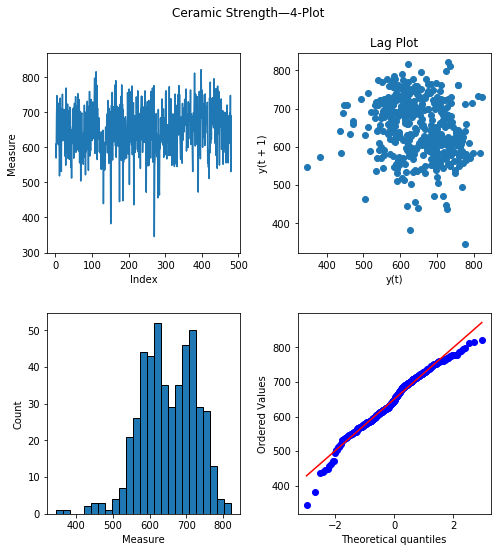

In [6]:
four_plot(df["Y"], main_title="Ceramic Strength—4-Plot",
         hist_kws={"bins": 25})

This 4-plot shows:
1. The run sequence plot (upper left corner) shows that the location and scale are relatively constant. It also shows a few outliers on the low side. Most of the points are in the range 500 to 750. However, there are about half a dozen points in the 300 to 450 range that may require special attention.

    A run sequence plot is useful for designed experiments in that it can reveal time effects. Time is normally a nuisance factor. That is, the time order on which runs are made should not have a significant effect on the response. If a time effect does appear to exist, this means that there is a potential bias in the experiment that needs to be investigated and resolved.
    
    
2. The lag plot (the upper right corner) does not show any significant structure. This is another tool for detecting any potential time effect.


3. The histogram (the lower left corner) shows the response appears to be reasonably symmetric, but with a bimodal distribution.


4. The normal probability plot (the lower right corner) shows some curvature indicating that distributions other than the normal may provide a better fit.
    
---

## <a name="batch_effect"></a>Analysis of the Batch Effect
### Batch is a Nuisance Factor
The two nuisance factors in this experiment are the batch number and the lab. There are two batches and eight labs. Ideally, these factors will have minimal effect on the response variable.

We will investigate the batch factor first.

### Bihistogram

In [7]:
def bihistogram(series_1, series_2, labels=["Series 1", "Series_2"],
                bins=10, x_label="Measure", y_label="Count", title=None,
                edgecolor="k", show=True, save=False, **kwargs):

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True,
                             gridspec_kw={
                                 "left": 0.1, "right": 0.98,
                                 "top": 0.9, "bottom": 0.1,
                                 "wspace": 0.3, "hspace": 0,
                                 },
                             figsize=(6, 6))
    hist_1, hist_2 = axes

    # Calculation of shared bin edges for the 2 histograms
    all_values = np.append(np.array(series_1), np.array(series_2))
    _, bin_edges = np.histogram(all_values, bins=bins)
    
    histogram(series_1, bins=bin_edges, x_label=None, y_label=y_label,
              ax=hist_1, show=False, **kwargs)
    
    histogram(series_2, bins=bin_edges, x_label=x_label, y_label=y_label,
              ax=hist_2, show=False, **kwargs)
    hist_2.invert_yaxis()

    hist_1.annotate(labels[0], xy=(0.02, 0.9), xycoords="axes fraction")
    hist_2.annotate(labels[1], xy=(0.02, 0.05), xycoords="axes fraction")
    fig.suptitle(title)

    show_and_save_plot(show=show, save=save, filename="bihistogram.png")

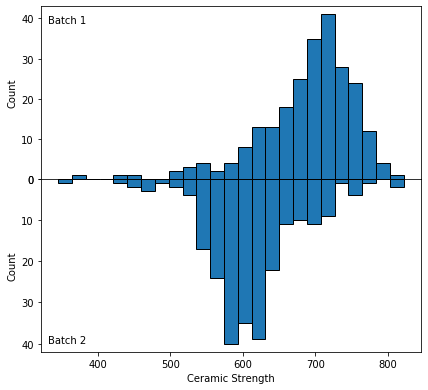

In [8]:
batch_1 = df[df["Batch"]==1]["Y"]
batch_2 = df[df["Batch"]==2]["Y"]
bihistogram(batch_1, batch_2, labels=["Batch 1", "Batch 2"], bins=25,
           x_label="Ceramic Strength")

This bihistogram shows the following.

1. There does appear to be a batch effect.


2. The batch 1 responses are centered at 700 while the batch 2 responses are centered at 625. That is, the batch effect is approximately 75 units.


3. The variability is comparable for the 2 batches.


4. Batch 1 has some skewness in the lower tail. Batch 2 has some skewness in the center of the distribution, but not as much in the tails compared to batch 1.


5. Both batches have a few low-lying points.


Although we could stop with the bihistogram, we will show a few other commonly used two-sample graphical techniques for comparison.

### Quantile-Quantile Plot 

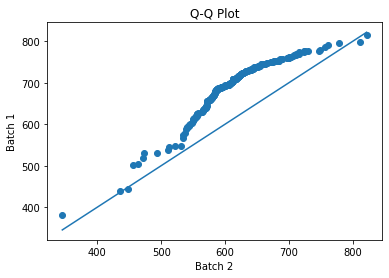

In [9]:
qq_plot(batch_2, batch_1, x_label="Batch 2", y_label="Batch 1")

This q-q plot shows the following.


1. Except for a few points in the right tail, the batch 1 values have higher quantiles than the batch 2 values. This implies that batch 1 has a greater location value than batch 2.


2. The q-q plot is not linear. This implies that the difference between the batches is not explained simply by a shift in location. That is, the variation and/or skewness varies as well. From the bihistogram, it appears that the skewness in batch 2 is the most likely explanation for the non-linearity in the q-q plot. 

### Box Plot 

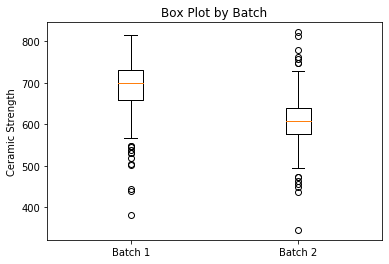

In [10]:
plt.boxplot([batch_1, batch_2], labels=["Batch 1", "Batch 2"])
plt.ylabel("Ceramic Strength")
plt.title("Box Plot by Batch")
plt.show()

This box plot shows the following.

 
1. The median for batch 1 is approximately 700 while the median for batch 2 is approximately 600.


2. The spread is reasonably similar for both batches, maybe slightly larger for batch 1.


3. Both batches have a number of outliers on the low side. Batch 2 also has a few outliers on the high side. Box plots are a particularly effective method for identifying the presence of outliers.

### Block Plots
A block plot is generated for each of the eight labs, with "1" and "2" denoting the batch numbers. In the first plot, we do not include any of the primary factors. The next 3 block plots include one of the primary factors. Note that each of the 3 primary factors (table speed = X1, down feed rate = X2, wheel grit size = X3) has 2 levels. With 8 labs and 2 levels for the primary factor, we would expect 16 separate blocks on these plots. The fact that some of these blocks are missing indicates that some of the combinations of lab and primary factor are empty.

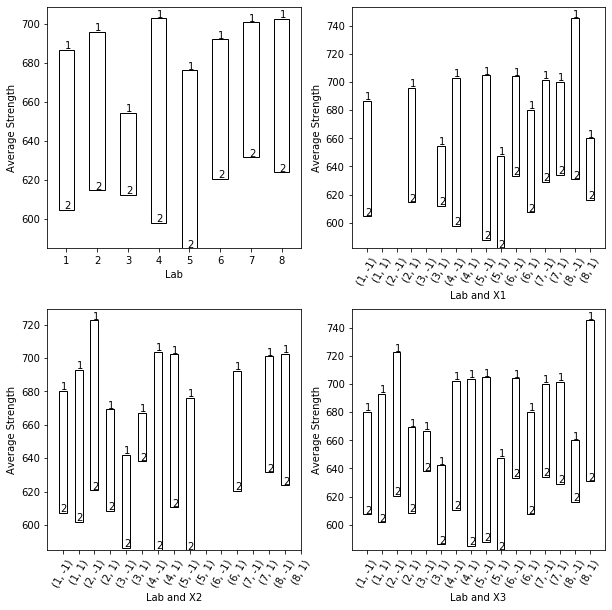

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, gridspec_kw={"hspace": 0.25},
                         figsize=(10, 10))

bp_lab, bp_lab_x1 = axes[0]
bp_lab_x2, bp_lab_x3 = axes[1]

# Block Plot 1: By "Lab"
block_plot(df, "Y", "Batch", ["Lab"], x_label="Lab",
           y_label="Average Strength", ax=bp_lab, show=False)

# Block Plot 2: By "Lab" and "X1"
block_plot(df, "Y", "Batch", ["Lab", "X1"], x_label="Lab and X1",
           y_label="Average Strength", ax=bp_lab_x1, show=False)

# Block Plot 3: By "Lab" and "X2"
block_plot(df, "Y", "Batch", ["Lab", "X2"], x_label="Lab and X2",
           y_label="Average Strength", ax=bp_lab_x2, show=False)

# Block Plot 3: By "Lab" and "X3"
block_plot(df, "Y", "Batch", ["Lab", "X3"], x_label="Lab and X3",
           y_label="Average Strength", ax=bp_lab_x3, show=False)

plt.show()

These block plots show the following.


1. The mean for batch 1 is greater than the mean for batch 2 in all of the cases above. This is strong evidence that the batch effect is real and consistent across labs and primary factors. 

### Quantitative Techniques
We can confirm some of the conclusions drawn from the above graphics by using quantitative techniques. The *F*-test can be used to test whether or not the variances from the two batches are equal and the two sample *t*-test can be used to test whether or not the means from the two batches are equal. Summary statistics for each batch are shown below.

In [12]:
df[["Y", "Batch"]].groupby("Batch").describe()

Y                                                                  \
       count        mean        std      min        25%       50%        75%   
Batch                                                                          
1      240.0  688.998642  65.549090  382.133  659.52600  698.3985  731.00250   
2      240.0  611.155975  61.854249  345.294  577.06475  608.1525  640.28775   

                
           max  
Batch           
1      815.754  
2      821.654

### *F*-Test
The two-sided [*F*-test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda359.htm) indicates that the variances for the two batches are not significantly different at the 5% level.

In [13]:
def f_test(series_1, series_2, alpha=0.05):
    var_1 = np.var(series_1, ddof=1)
    var_2 = np.var(series_2, ddof=1)
    
    # F = larger_variance / smaller_variance
    if var_1 >= var_2:
        F = var_1 / var_2
        deg_1 = len(series_1) - 1
        deg_2 = len(series_2) - 1
    else:
        F = var_2 / var_1
        deg_1 = len(series_2) - 1
        deg_2 = len(series_1) - 1
    
    critical_value = stats.f.ppf(1-alpha/2, deg_1, deg_2)
    p_value = 1 - stats.f.cdf(F, deg_1, deg_2)
    
    return F, critical_value, p_value

In [14]:
F, F_crit, p = f_test(batch_1, batch_2)

print("F =", F)
print("Critical value =", F_crit)
print("p-value =", p)

F = 1.1230375233083825
Critical value = 1.2893844022512682
p-value = 0.18519146513473972


### Two Sample *t*-Test
Since the *F*-test indicates that the two batch variances are equal, we can pool the variances for the two-sided, two-sample *t*-test to compare batch means.

The *t*-test indicates that the mean for batch 1 is larger than the mean for batch 2 at the 5% significance level.

In [15]:
statistic, p_value = stats.ttest_ind(batch_1, batch_2)
print("Statistic =", statistic)
print("p-value =", p_value)

Statistic = 13.380580525978077
p-value = 6.618687049417706e-35


### Conclusions
We can draw the following conclusions from the above analysis.


1. There is in fact a significant batch effect. This batch effect is consistent across labs and primary factors.


2. The magnitude of the difference is on the order of 75 to 100 (with batch 2 being smaller than batch 1). The standard deviations do not appear to be significantly different.


3. There is some skewness in the batches. 


This batch effect was completely unexpected by the scientific investigators in this study.

Note that although the quantitative techniques support the conclusions of unequal means and equal standard deviations, they do not show the more subtle features of the data such as the presence of outliers and the skewness of the batch 2 data.

---

## <a name="lab_effect"></a>Analysis of the Lab Effect
### Box Plot
The next matter is to determine if there is a lab effect. The first step is to generate a box plot for the ceramic strength based on the lab.

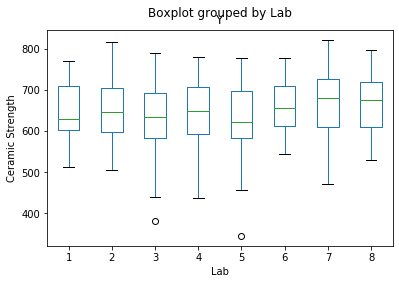

In [16]:
box_plot(df, column="Y", group="Lab", x_label="Lab", y_label="Ceramic Strength",
        grid=False)

This box plot shows the following.

1. There is minor variation in the medians for the 8 labs.


2. The scales are relatively constant for the labs.


3. Two of the labs (3 and 5) have outliers on the low side. 

### Box Plot for Batch 1
Given that the previous section showed a distinct batch effect, the next step is to generate the box plots for the two batches separately. 

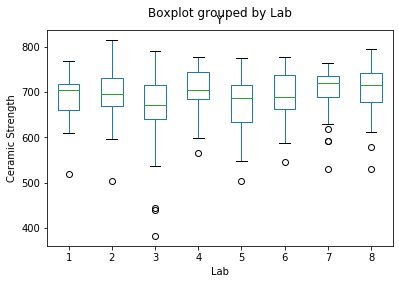

In [17]:
box_plot(df[df["Batch"]==1], column="Y", group="Lab", x_label="Lab",
         y_label="Ceramic Strength", grid=False)

This box plot shows the following.


1. Each of the labs has a median in the 650 to 700 range.


2. The variability is relatively constant across the labs.


3. Each of the labs has at least one outlier on the low side. 

### Box Plot for Batch 2 

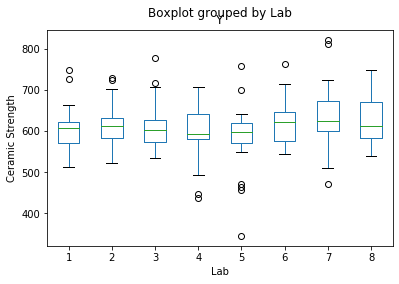

In [18]:
box_plot(df[df["Batch"]==2], column="Y", group="Lab", x_label="Lab",
         y_label="Ceramic Strength", grid=False)

This box plot shows the following.


1. The medians are in the range 550 to 600.


2. There is a bit more variability, across the labs, for batch2 compared to batch 1.


3. Six of the eight labs show outliers on the high side. Three of the labs show outliers on the low side. 

### Conclusions
We can draw the following conclusions about a possible lab effect from the above box plots.

1. The batch effect (of approximately 75 to 100 units) on location dominates any lab effects.


2. It is reasonable to treat the labs as homogeneous.
    
---

## <a name="primary_factors"></a>Analysis of Primary Factors
### Main effects
The first step in analyzing the primary factors is to determine which factors are the most significant. The [DOE scatter plot](https://www.itl.nist.gov/div898/handbook/eda/section3/dexsplot.htm), [DOE mean plot](https://www.itl.nist.gov/div898/handbook/eda/section3/dexmeanp.htm), and the [DOE standard deviation plot](https://www.itl.nist.gov/div898/handbook/eda/section3/dexsdplo.htm) will be the primary tools, with "DOE" being short for "design of experiments".

Since the previous pages showed a significant batch effect but a minimal lab effect, we will generate separate plots for batch 1 and batch 2. However, the labs will be treated as equivalent.

### DOE Scatter Plot for Batch 1 

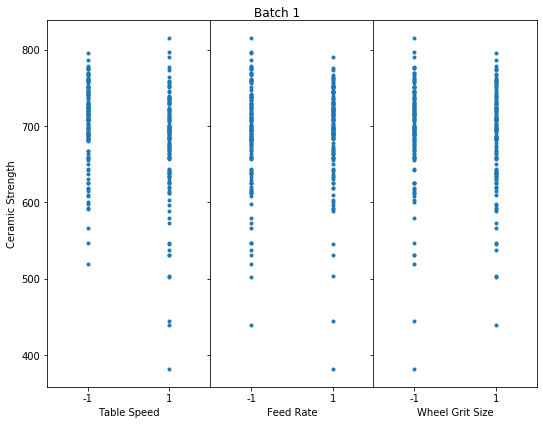

In [19]:
doe_scatter_plot(df[df["Batch"]==1], "Y", ["X1", "X2", "X3"],
                 x_labels=["Table Speed", "Feed Rate", "Wheel Grit Size"],
                 y_label="Ceramic Strength", title="Batch 1", marker=".")

This DOE scatter plot shows the following for batch 1.


1. Most of the points are between 500 and 800.


2. There are about a dozen or so points between 300 and 500.


3. Except for the outliers on the low side (i.e., the points between 300 and 500), the distribution of the points is comparable for the 3 primary factors in terms of location and spread. 

### DOE Mean Plot for Batch 1

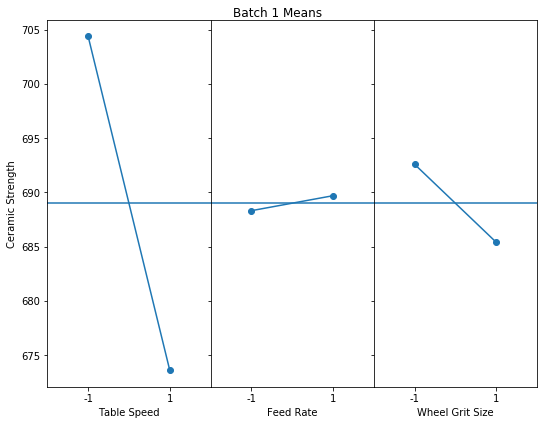

In [20]:
doe_statistic_plot(df[df["Batch"]==1], "Y", ["X1", "X2", "X3"],
                   x_labels=["Table Speed", "Feed Rate", "Wheel Grit Size"],
                   y_label="Ceramic Strength", title="Batch 1 Means",
                   show_overall_statistic=True, marker="o")

This DOE mean plot shows the following for batch 1.


1. The table speed factor (X1) is the most significant factor with an effect, the difference between the two points, of approximately 35 units.


2. The wheel grit factor (X3) is the next most significant factor with an effect of approximately 10 units.


3. The feed rate factor (X2) has minimal effect. 

### DOE SD Plot for Batch 1

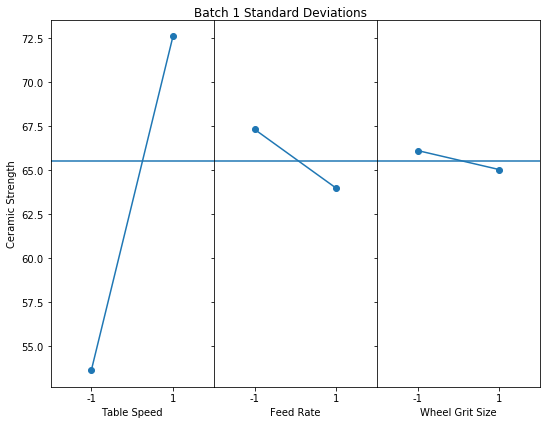

In [21]:
doe_statistic_plot(df[df["Batch"]==1], "Y", ["X1", "X2", "X3"], statistic="std",
                   x_labels=["Table Speed", "Feed Rate", "Wheel Grit Size"],
                   y_label="Ceramic Strength", title="Batch 1 Standard Deviations",
                   show_overall_statistic=True, marker="o")

This DOE standard deviation plot shows the following for batch 1.


1. The table speed factor (X1) has a significant difference in variability between the levels of the factor. The difference is approximately 20 units.


2. The wheel grit factor (X3) and the feed rate factor (X2) have minimal differences in variability. 

### DOE Scatter Plot for Batch 2

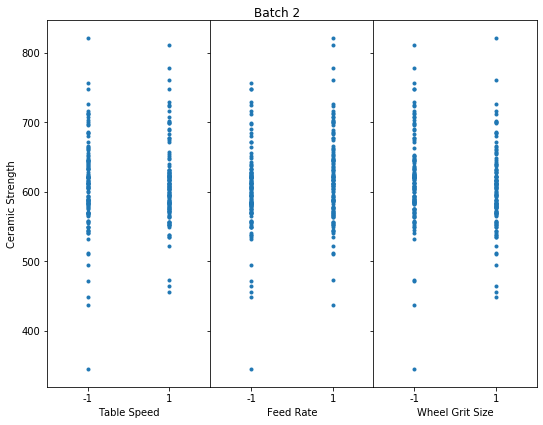

In [22]:
doe_scatter_plot(df[df["Batch"]==2], "Y", ["X1", "X2", "X3"],
                 x_labels=["Table Speed", "Feed Rate", "Wheel Grit Size"],
                 y_label="Ceramic Strength", title="Batch 2", marker=".")

This DOE scatter plot shows the following for batch 2.


1. Most of the points are between 450 and 750.


2. There are a few outliers on both the low side and the high side.


3. Except for the outliers (i.e., the points less than 450 or greater than 750), the distribution of the points is comparable for the 3 primary factors in terms of location and spread. 

### DOE Mean Plot for Batch 2 

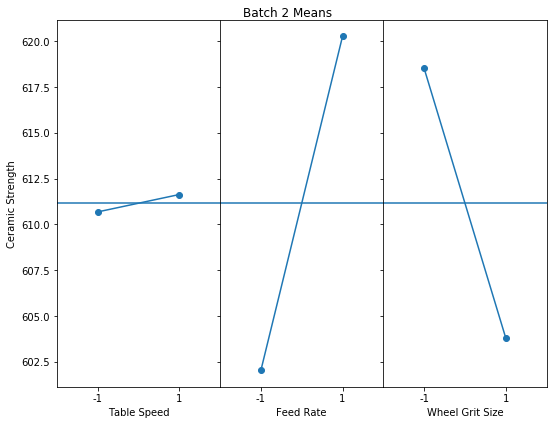

In [23]:
doe_statistic_plot(df[df["Batch"]==2], "Y", ["X1", "X2", "X3"],
                   x_labels=["Table Speed", "Feed Rate", "Wheel Grit Size"],
                   y_label="Ceramic Strength", title="Batch 2 Means",
                   show_overall_statistic=True, marker="o")

This DOE mean plot shows the following for batch 2.


1. The feed rate (X2) and wheel grit (X3) factors have an approximately equal effect of about 15 or 20 units.


2. The table speed factor (X1) has a minimal effect. 

### DOE SD Plot for Batch 2 	

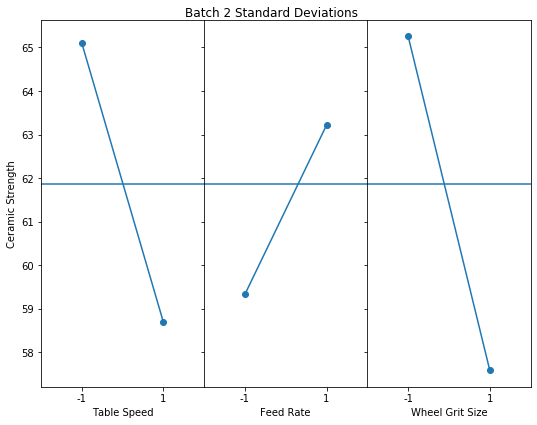

In [24]:
doe_statistic_plot(df[df["Batch"]==2], "Y", ["X1", "X2", "X3"], statistic="std",
                   x_labels=["Table Speed", "Feed Rate", "Wheel Grit Size"],
                   y_label="Ceramic Strength", title="Batch 2 Standard Deviations",
                   show_overall_statistic=True, marker="o")

This DOE standard deviation plot shows the following for batch 2.


1. The difference in the standard deviations is roughly comparable for the three factors (slightly less for the feed rate factor). 

### Interaction Effects
The above plots graphically show the main effects. An additonal concern is whether or not there any significant interaction effects.

Main effects and 2-term interaction effects are discussed in the chapter on [Process Improvement](https://www.itl.nist.gov/div898/handbook/pri/pri.htm).

In the following [DOE interaction plots](https://www.itl.nist.gov/div898/handbook/eda/section3/dexmeanp.htm), the labels on the plot give the variables and the estimated effect. For example, factor 1 is table speed and it has an estimated effect of 30.77 (it is actually -30.77 if the direction is taken into account).

### DOE Interaction Plot for Batch 1 

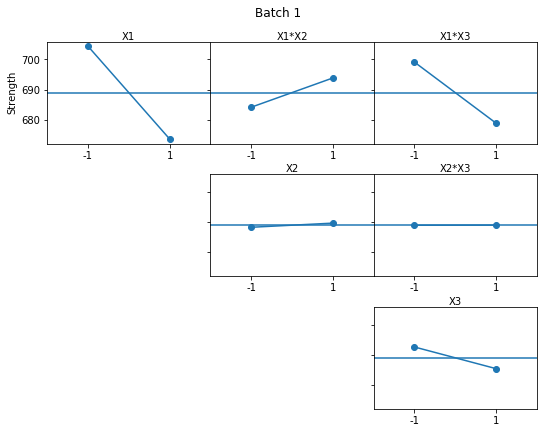

In [25]:
doe_statistic_matrix(df[df["Batch"]==1], "Y", ["X1", "X2", "X3"], y_label="Strength",
                     title="Batch 1", show_overall_statistic=True, marker="o")

The ranked list of factors for batch 1 is:


1. Table speed (X1) with an estimated effect of -30.77.


2. The interaction of table speed (X1) and wheel grit (X3) with an estimated effect of -20.25.


3. The interaction of table speed (X1) and feed rate (X2) with an estimated effect of 9.7.


4. Wheel grit (X3) with an estimated effect of -7.18.


5. Down feed (X2) and the down feed interaction with wheel grit (X3) are essentially zero. 

### DOE Interaction Plot for Batch 2 

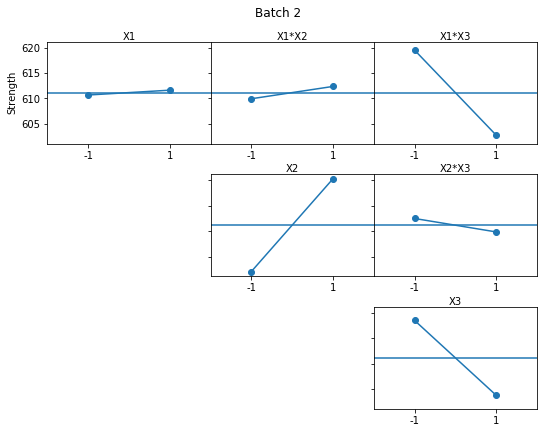

In [26]:
doe_statistic_matrix(df[df["Batch"]==2], "Y", ["X1", "X2", "X3"], y_label="Strength", 
                     title="Batch 2", show_overall_statistic=True, marker="o")

The ranked list of factors for batch 2 is:


1. Down feed (X2) with an estimated effect of 18.22.


2. The interaction of table speed (X1) and wheel grit (X3) with an estimated effect of -16.71.


3. Wheel grit (X3) with an estimated effect of -14.71


4. Remaining main effect and 2-factor interaction effects are essentially zero.

### Conclusions

From the above plots, we can draw the following overall conclusions.


1. The batch effect (of approximately 75 units) is the dominant primary factor.


2. The most important factors differ from batch to batch. See the above text for the ranked list of factors with the estimated effects. 
    
---